# Importing necessary libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import imghdr
import tensorflow as tf
import keras_tuner
import numpy as np

C:\Users\razan\AppData\Local\Temp\ipykernel_8872\2368011593.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Loading Data

## You can look at the images by this code

In [3]:
# for folder in os.listdir("Data"):
#     print(f"********************************************{folder}********************************************")
#     for image in os.listdir(os.path.join("Data", folder))[:10]:
#         image_as_an_array = cv2.imread(os.path.join("Data", folder, image))
#         converted_image = cv2.cvtColor(image_as_an_array, cv2.COLOR_RGB2BGR)
#         plt.imshow(converted_image)
#         plt.axis("off")
#         plt.show()

In [4]:
extensions_supported_by_tensorflow = ["bmp", "gif", "jpeg", "png"]

for folder in os.listdir("Data"):
    print(f"********************************************{folder}********************************************")
    for image in os.listdir(os.path.join("Data", folder)):
        file_name = os.path.join("Data", folder, image)
        try:
            image_as_an_array = cv2.imread(file_name)
            extension = imghdr.what(file_name)

            if extension not in extensions_supported_by_tensorflow:
                os.remove(file_name)
                print(f"{file_name} has been removed")
        except Exception as e:
            print(f"There is an issues with {file_name}")

********************************************Happy People********************************************
********************************************Sad People********************************************


In [5]:
data = tf.keras.utils.image_dataset_from_directory("Data")

Found 322 files belonging to 2 classes.


In [6]:
f"There are total {len(data)} batches, each of 32 images in my data"

'There are total 11 batches, each of 32 images in my data'

In [7]:
data = data.map(lambda x, y: (x / 255, y))

In [8]:
images_iterator = data.as_numpy_iterator()

In [9]:
X, y = images_iterator.next()

In [10]:
X

array([[[[0.07843138, 0.08235294, 0.09019608],
         [0.07809436, 0.08201593, 0.08985907],
         [0.0765625 , 0.08048407, 0.08832721],
         ...,
         [0.17591912, 0.2033701 , 0.17591912],
         [0.16672795, 0.19417892, 0.16672795],
         [0.16470589, 0.19215687, 0.16470589]],

        [[0.07843138, 0.08235294, 0.09019608],
         [0.07809436, 0.08201593, 0.08985907],
         [0.0765625 , 0.08048407, 0.08832721],
         ...,
         [0.17625612, 0.20370711, 0.17625612],
         [0.16706495, 0.19451593, 0.16706495],
         [0.16504289, 0.19249387, 0.16504289]],

        [[0.07843138, 0.08235294, 0.09019608],
         [0.07809436, 0.08201593, 0.08985907],
         [0.0765625 , 0.08048407, 0.08832721],
         ...,
         [0.17778799, 0.20523897, 0.17778799],
         [0.16859682, 0.1960478 , 0.16859682],
         [0.16657476, 0.19402574, 0.16657476]],

        ...,

        [[0.290962  , 0.318413  , 0.2556679 ],
         [0.28943756, 0.31688854, 0.25382224]

In [11]:
y

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

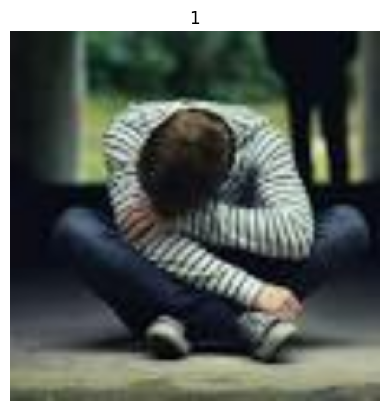

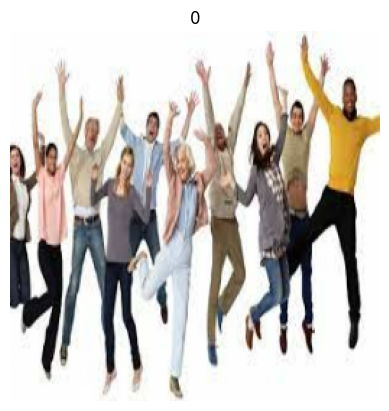

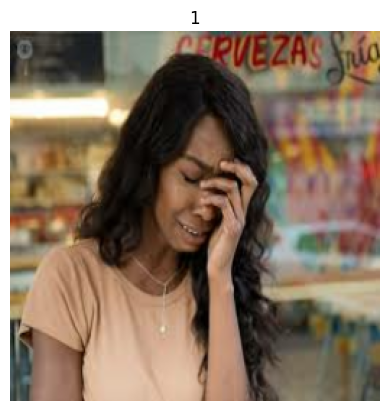

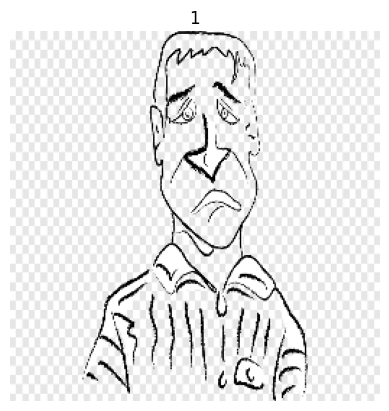

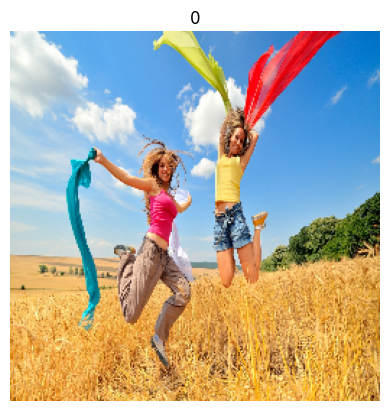

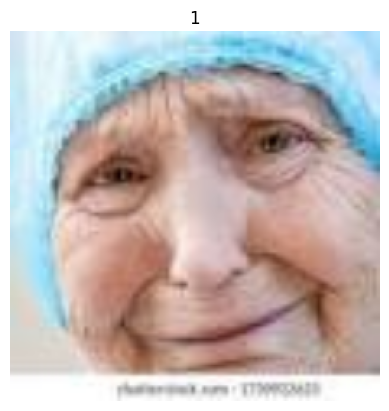

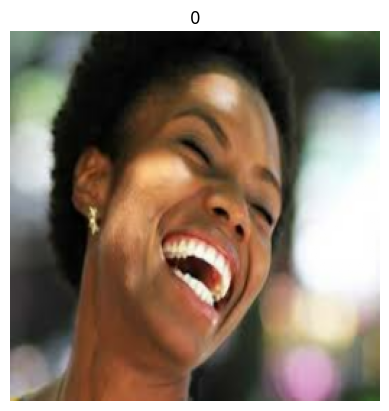

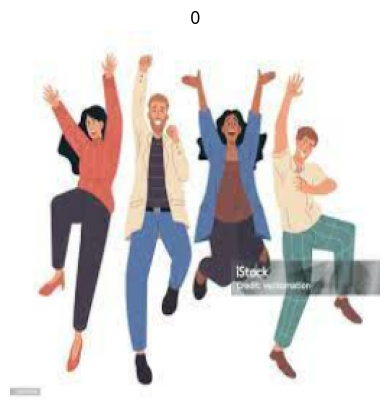

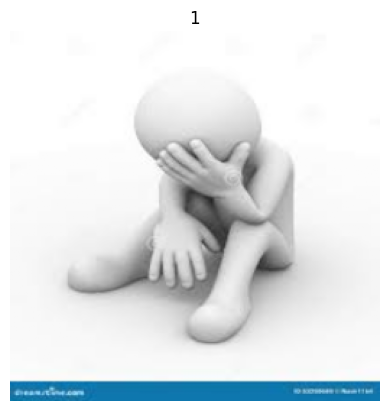

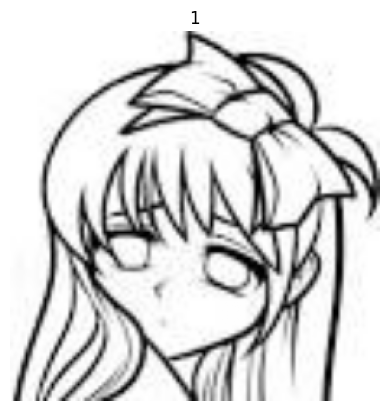

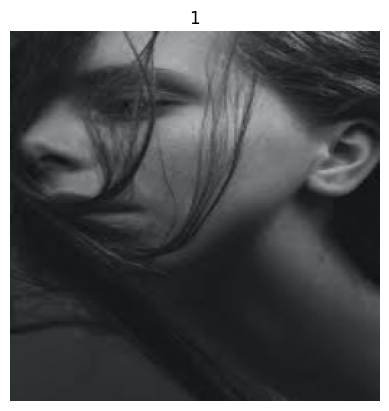

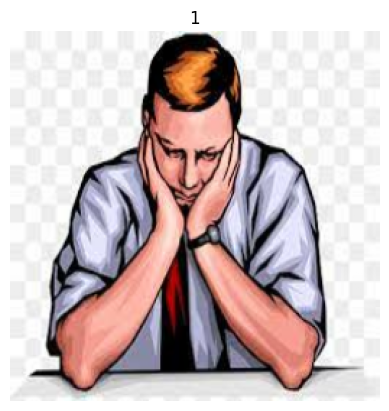

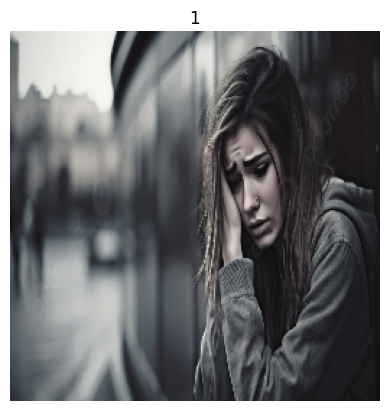

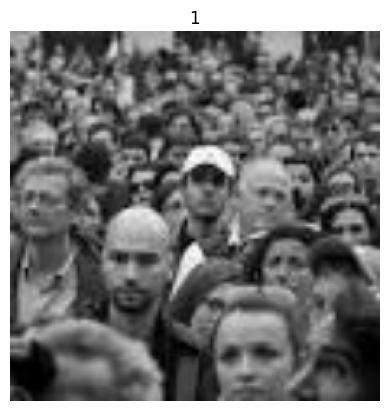

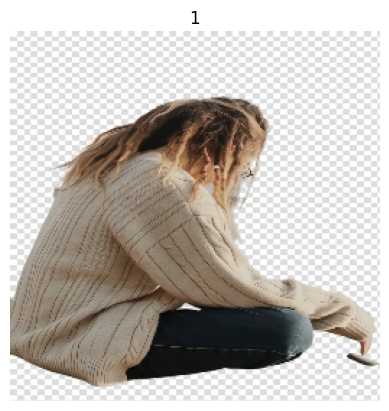

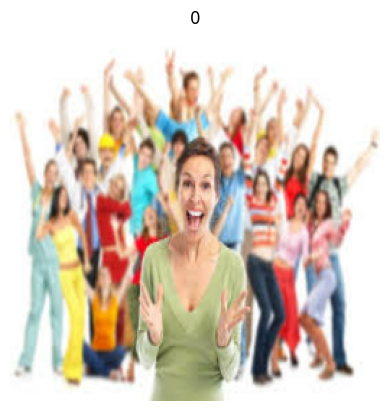

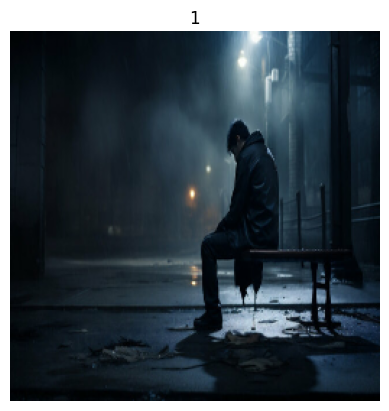

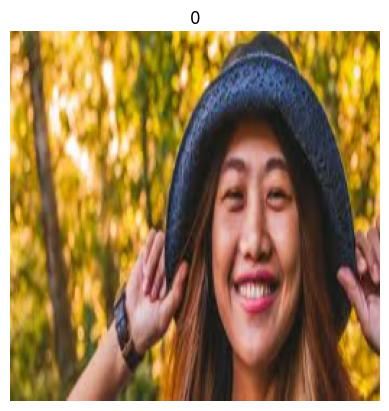

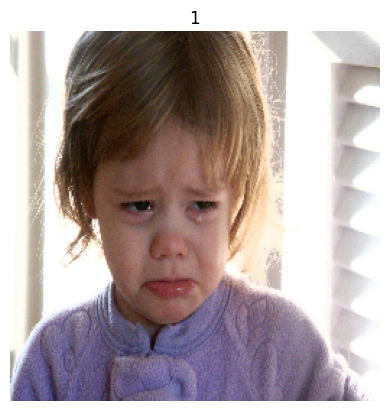

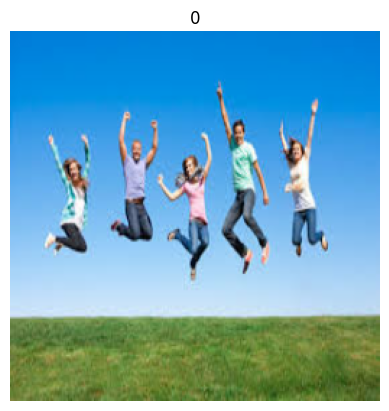

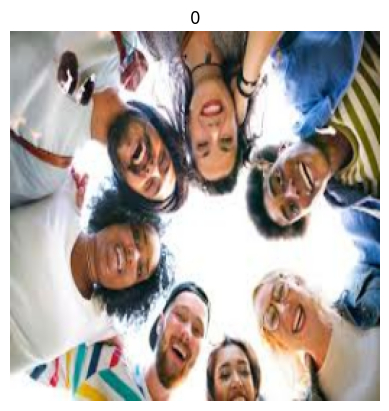

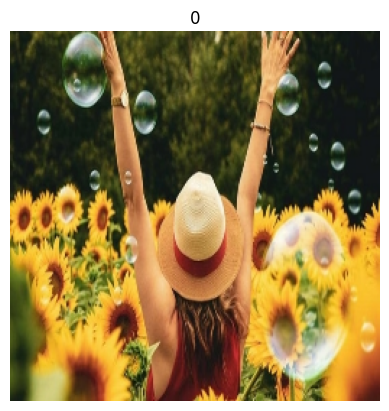

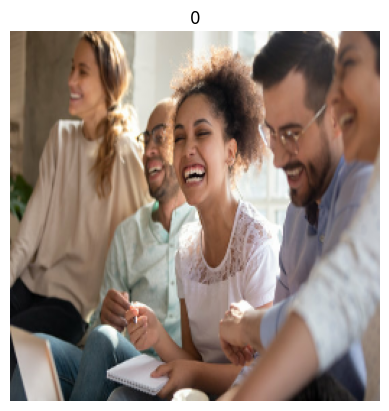

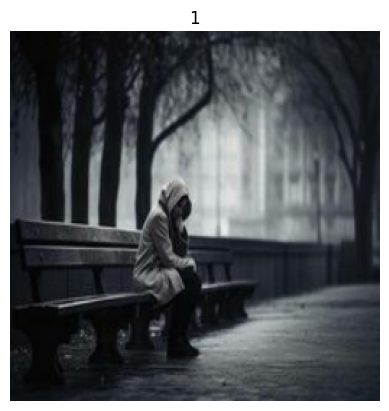

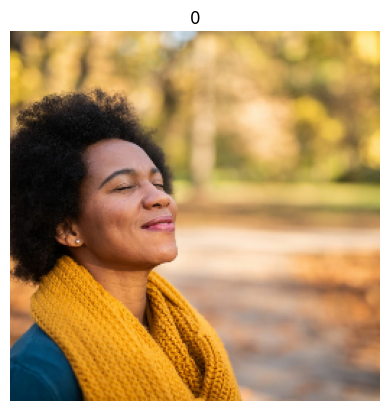

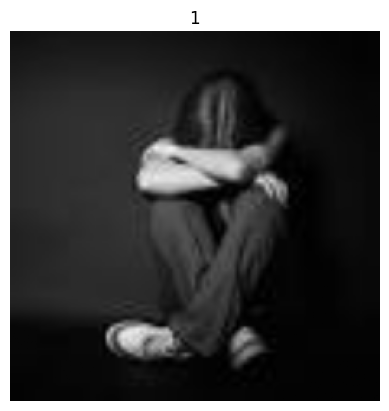

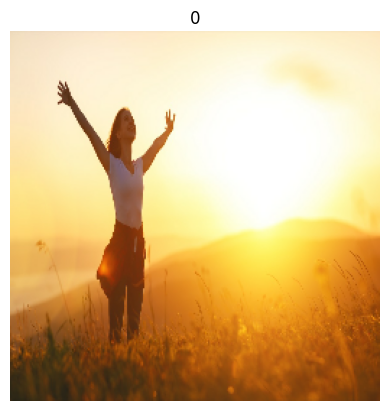

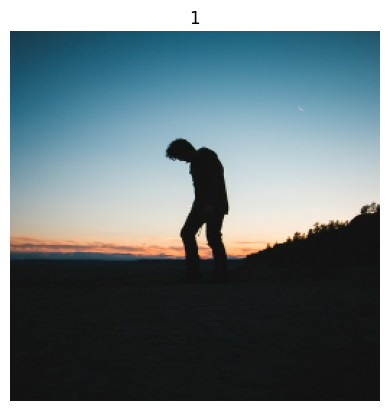

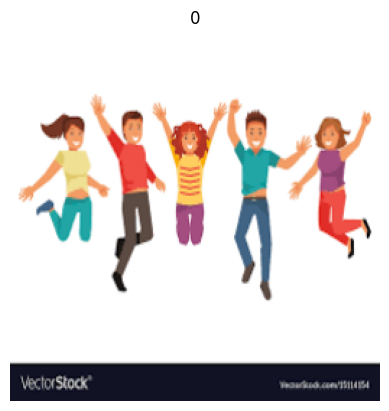

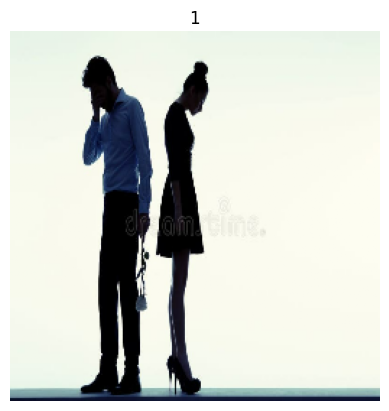

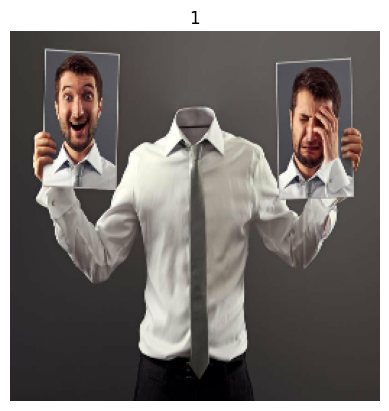

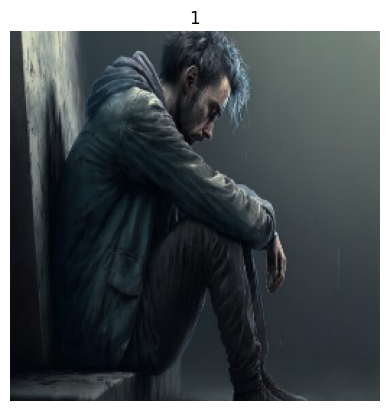

In [12]:
for image, label in zip(X, y):
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    plt.show()

## from above understanding, we can conclude that 0 is for happy and 1 is for sad

In [13]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)

print(train_size, val_size, test_size)

8 1 1


In [14]:
train_ds = data.take(train_size)
val_ds = data.skip(train_size).take(val_size)
test_ds = data.skip(train_size + val_size).take(test_size)

In [15]:
X, y = train_ds.as_numpy_iterator().next()
y

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0])

In [16]:
len(train_ds)

8

In [17]:
len(val_ds)

1

In [18]:
len(test_ds)

1

In [19]:
train_ds.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

1 - no. of layers
2 - filters
3 - padding: either valid or same

In [42]:
def build_model(hp):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Input(shape = (256, 256, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ])
    
    model = tf.keras.Sequential()
    
    model.add(data_augmentation)

    for i in range(hp.Int("number_of_layers", 1, 5)):
        model.add(
            tf.keras.layers.Conv2D(
                hp.Choice(f"filters_{i}", [16, 32, 64, 128]),
                (3, 3),
                1,
                activation = "relu",
                padding = hp.Choice(f"padding_{i}", ["same", "valid"])))
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Flatten())

    model.add(
        tf.keras.layers.Dense(
            hp.Choice("neurons", [16, 32, 64, 128, 256]),
                   activation = "relu"))

    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate = 0.25))
              
    model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
              
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ["accuracy"])

    return model

In [43]:
build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_3, built=False>

In [44]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective = "val_accuracy",
    directory="my_dir",
    project_name="helloworld",
    overwrite = True
)

In [46]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
number_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
filters_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
padding_0 (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}
neurons (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}


In [47]:
tuner.search(train_ds, epochs = 5, validation_data = val_ds)

Trial 10 Complete [00h 01m 13s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.84375
Total elapsed time: 00h 26m 52s


In [51]:
tuner.get_best_hyperparameters()[0].values

{'number_of_layers': 2,
 'filters_0': 32,
 'padding_0': 'same',
 'neurons': 256,
 'dropout': False,
 'filters_1': 16,
 'padding_1': 'same'}

In [54]:
best_model = tuner.get_best_models(num_models = 1)[0]

In [55]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,783,249 (64.02 MB)

 Trainable params: 16,783,249 (64.02 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
number_of_layers: 2
filters_0: 32
padding_0: same
neurons: 256
dropout: False
filters_1: 16
padding_1: same
Score: 0.84375

Trial 02 summary
Hyperparameters:
number_of_layers: 3
filters_0: 64
padding_0: same
neurons: 16
dropout: True
filters_1: 16
padding_1: valid
filters_2: 16
padding_2: same
Score: 0.8125

Trial 03 summary
Hyperparameters:
number_of_layers: 4
filters_0: 64
padding_0: same
neurons: 32
dropout: True
filters_1: 64
padding_1: same
filters_2: 32
padding_2: same
filters_3: 16
padding_3: same
Score: 0.8125

Trial 09 summary
Hyperparameters:
number_of_layers: 4
filters_0: 32
padding_0: same
neurons: 16
dropout: True
filters_1: 16
padding_1: same
filters_2: 16
padding_2: valid
filters_3: 16
padding_3: same
filters_4: 64
padding_4: same
Score: 0.8125

Trial 04 summary
Hyperparameters:
number_of_layers: 5
filters_0: 128
padding_0

In [57]:
log_dir = "Logs"

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [59]:
history = best_model.fit(train_ds, epochs = 20, initial_epoch = 6, validation_data = val_ds, callbacks = [tensorboard_callback])

Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7167 - loss: 0.5675 - val_accuracy: 0.7188 - val_loss: 0.4639
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7599 - loss: 0.5295 - val_accuracy: 0.7500 - val_loss: 0.5855
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7597 - loss: 0.5620 - val_accuracy: 0.5625 - val_loss: 0.7984
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7398 - loss: 0.5475 - val_accuracy: 0.8125 - val_loss: 0.5697
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7949 - loss: 0.5221 - val_accuracy: 0.8438 - val_loss: 0.3533
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8371 - loss: 0.4215 - val_accuracy: 0.9062 - val_loss: 0.4193
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7722 - loss: 0.4868 - val_accuracy: 0.7500 - val_loss: 0.3696
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7503 - loss: 0.5382 - val_accuracy: 0.7812 - val_loss: 0.4759
Epo

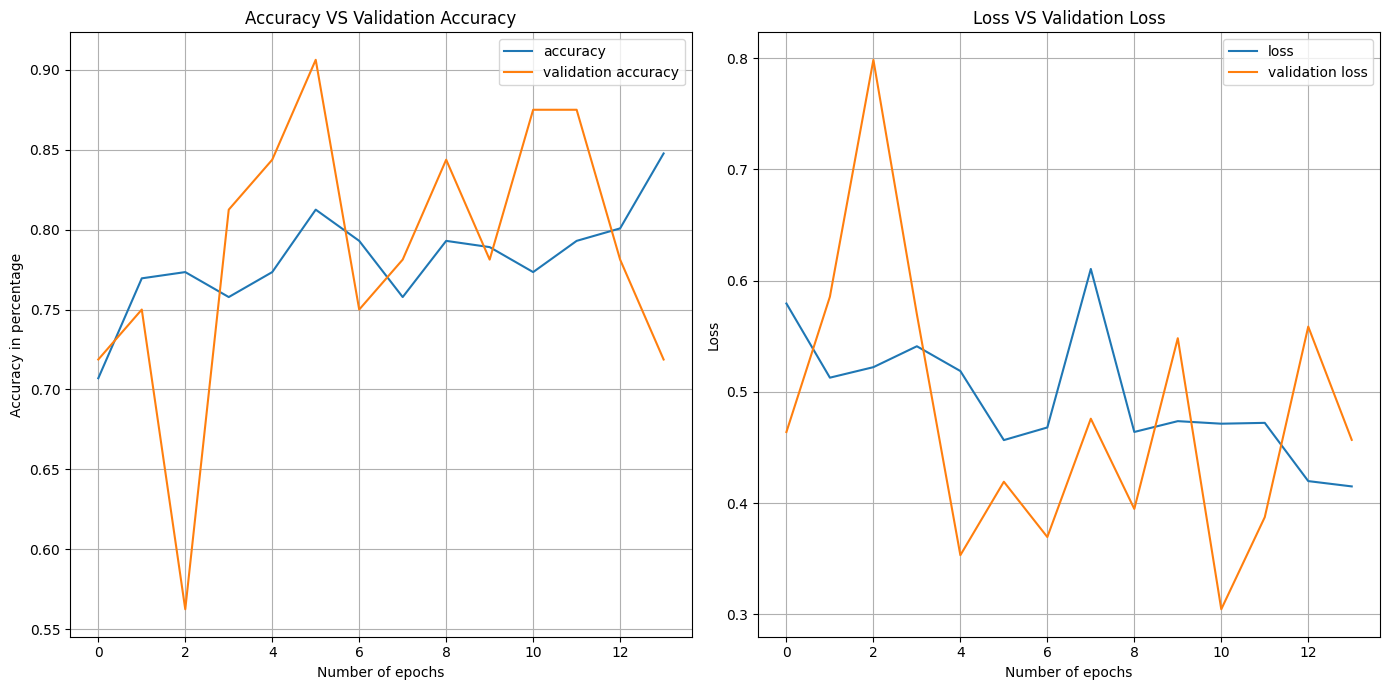

In [60]:
fig, axis = plt.subplots(ncols = 2, figsize = (14, 7))

axis[0].plot(history.history["accuracy"], label = "accuracy")
axis[0].plot(history.history["val_accuracy"], label = "validation accuracy")
axis[0].set_xlabel("Number of epochs")
axis[0].set_ylabel("Accuracy in percentage")
axis[0].set_title("Accuracy VS Validation Accuracy")
axis[0].grid(True)
axis[0].legend()

axis[1].plot(history.history["loss"], label = "loss")
axis[1].plot(history.history["val_loss"], label = "validation loss")
axis[1].set_xlabel("Number of epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Loss VS Validation Loss")
plt.grid(True)
axis[1].legend()

plt.tight_layout()
plt.show()

In [62]:
predictions = best_model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [63]:
predictions = predictions.flatten()

In [64]:
predictions = [1 if prediction > 0.5 else 0 for prediction in predictions]

In [65]:
X, y = test_ds.as_numpy_iterator().next()

In [3]:
for actual_value, prediction in zip(np.array(predictions), y):
    print(actual_value, prediction)

NameError: name 'predictions' is not defined

In [69]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

In [71]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    predictions = best_model.predict(X)
    precision.update_state(y, predictions)
    recall.update_state(y, predictions)
    binary_accuracy.update_state(y, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


In [72]:
print(precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy())

0.8888889 0.53333336 0.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


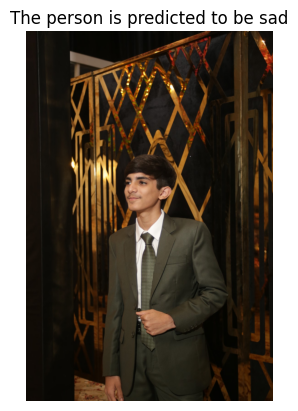

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


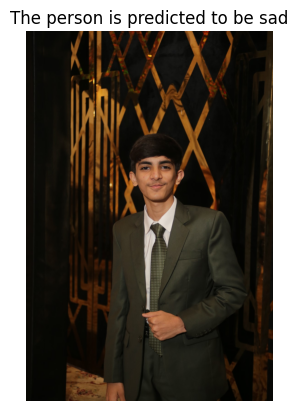

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


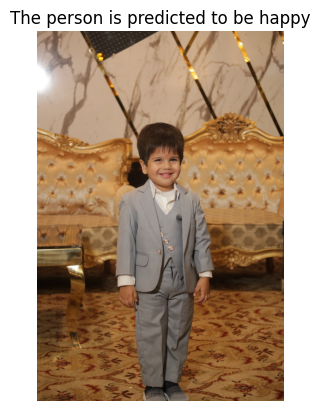

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


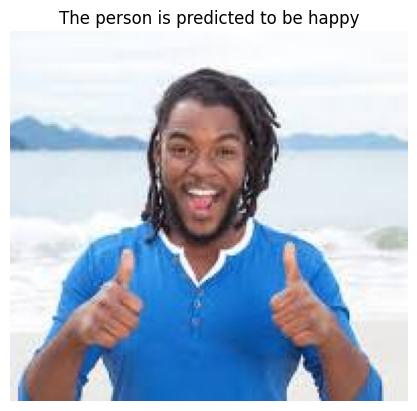

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


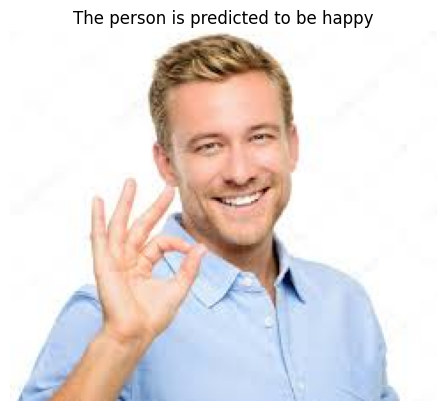

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


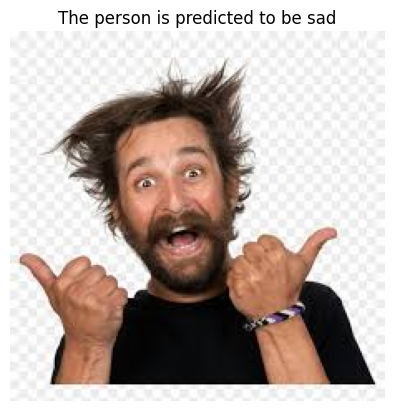

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


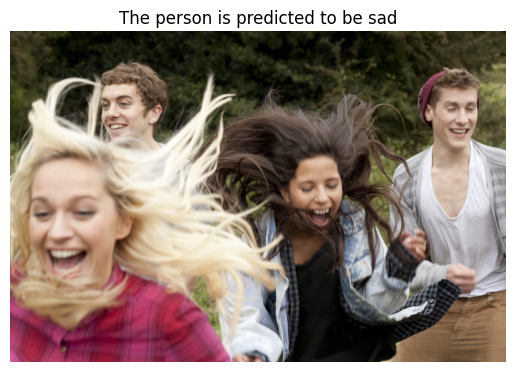

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


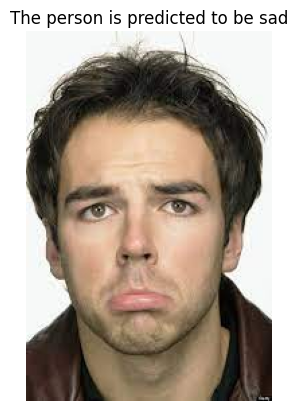

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


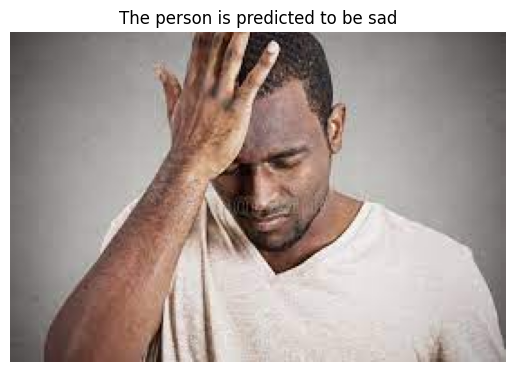

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


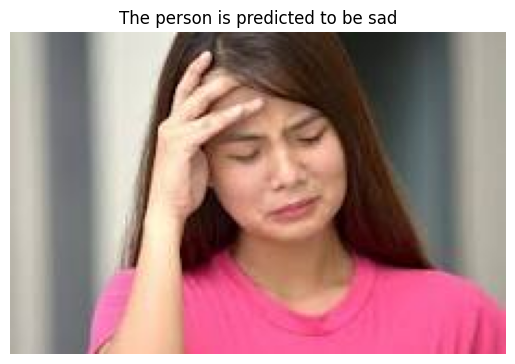

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


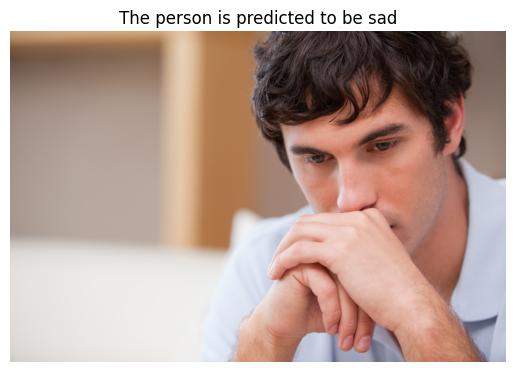

In [74]:
for image in os.listdir("Test Images"):
    image_as_an_array = cv2.imread(os.path.join("Test Images", image))
    resized_image = tf.image.resize(image_as_an_array, (256, 256))
    prediction = best_model.predict(np.expand_dims(resized_image / 255, 0))
    plt.imshow(cv2.cvtColor(image_as_an_array, cv2.COLOR_BGR2RGB))
    if prediction > 0.5:
        plt.title("The person is predicted to be sad")
    else:
        plt.title("The person is predicted to be happy")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.09555573]]


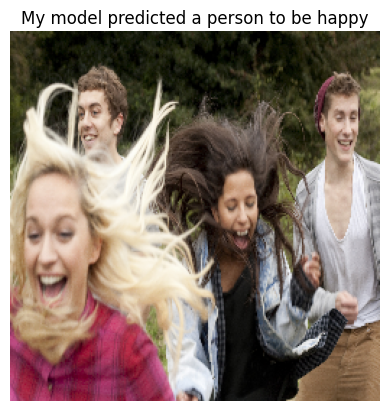

In [76]:
image_as_an_array = cv2.imread("Test Images/happy3.jpg")
converted_image = cv2.cvtColor(image_as_an_array, cv2.COLOR_BGR2RGB)
scaled_image = converted_image / 255
resized_image = cv2.resize(scaled_image, (256, 256))
expanded_dim_image = tf.expand_dims(resized_image, 0)
prediction = best_model.predict(expanded_dim_image)
plt.imshow(resized_image)
print(prediction)
if prediction > 0.5:
    plt.title("My model predicted a person to be sad")
else:
    plt.title("My model predicted a person to be happy")
plt.axis("off")
plt.show()

In [104]:
model_path = os.path.join("Model" , "happysadclassificationmodel.keras")

In [102]:
best_model.save(model_path)

In [103]:
loaded_model = tf.keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
[[0.02915142]]


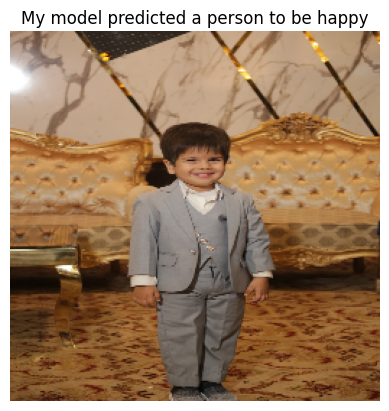

In [105]:
image_as_an_array = cv2.imread("Test Images/basim.jpg")
converted_image = cv2.cvtColor(image_as_an_array, cv2.COLOR_BGR2RGB)
scaled_image = converted_image / 255
resized_image = cv2.resize(scaled_image, (256, 256))
expanded_dim_image = tf.expand_dims(resized_image, 0)
prediction = loaded_model.predict(expanded_dim_image)
plt.imshow(resized_image)
print(prediction)
if prediction > 0.5:
    plt.title("My model predicted a person to be sad")
else:
    plt.title("My model predicted a person to be happy")
plt.axis("off")
plt.show()